In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp
from poola import core as pool
import anchors

import core_functions as fns

gpp.set_aesthetics(palette='Set2')

In [3]:
def run_guide_residuals(lfc_df, paired_lfc_cols=[]):
    '''
    Calls get_guide_residuals function from anchors package to calculate guide-level residual z-scores
    Inputs:
    1. lfc_df: data frame with log-fold changes (relative to pDNA)
    2. paired_lfc_cols: grouped list of initial populations and corresponding resistant populations 
    
    '''
    lfc_df = lfc_df.drop_duplicates()
    if not paired_lfc_cols:
        paired_lfc_cols = fns.pair_cols(lfc_df)[1] #get lfc pairs 
    modified = []
    unperturbed = []
    #reference_df: column1 = modifier condition, column2 = unperturbed column
    ref_df = pd.DataFrame(columns=['modified', 'unperturbed'])
    row = 0 #row index for reference df 
    for pair in paired_lfc_cols:
        #number of resistant pops in pair = len(pair)-1
        res_idx = 1 
        #if multiple resistant populations, iterate 
        while res_idx < len(pair): 
            ref_df.loc[row, 'modified'] = pair[res_idx]
            ref_df.loc[row, 'unperturbed'] = pair[0]
            res_idx +=1 
            row +=1
    
    print(ref_df)
    #input lfc_df, reference_df 
    #guide-level
    residuals_lfcs, all_model_info, model_fit_plots = anchors.get_guide_residuals(lfc_df, ref_df)
    return residuals_lfcs, all_model_info, model_fit_plots

def select_top_ranks(df, rank = 5, largest=True): #pick top ranks from each column of df with ranks, rank = top rank threshold (e.g. 5 if top 5)
    '''
    Inputs: 
    1. df: Dataframe with columns "Gene Symbol" and data used to rank 
    2. rank: top number of rows to select 
    Outputs:
    1. final_top_rank_df: Data frame with top ranked rows 
    '''
    rank_cols = df.columns.to_list()[1:]
    prev_top_rank_rows = pd.DataFrame(columns = df.columns)
    final_top_rank_df = pd.DataFrame() #for final list
    for col in rank_cols:
        #top_rank_rows = df.copy().loc[lambda df: df[col] <= rank, :] #pick rows with rank <= 5
        if largest:
            top_rank_rows = df.copy().nlargest(rank, col)
        else:
            top_rank_rows = df.copy().nsmallest(rank, col)
        top_rank_df = pd.concat([prev_top_rank_rows, top_rank_rows]) #concat with rows selected from previous column
        prev_top_rank_rows = top_rank_df #set combined list as previous

    final_top_rank_df = prev_top_rank_rows.drop_duplicates(subset = ['Gene Symbol']) #drop duplicate gene rows
    return final_top_rank_df


# A549 (ACE2)

**Cell line**: A549 overexpressing ACE2 <br/>
**Library**: Secondary CRISPRko library 

## Data summary
Note: A549 resistant population screen 2 had low match percentage (~60%) 

In [4]:
# Reads from Supplemental File 8
reads_A549 = pd.read_excel('Data/GSE193834_Supplemental_File_8_A549-ACE2_KO_SecondaryLibrary_Goujon.xlsx', sheet_name = 'A549_genomewide_reads')
reads_A549



,Construct Barcode,pDNA,A549-CP1658-initial population screen #1,A549-CP1658-resistant population screen #1,A549-CP1658-initial population screen #2,A549-CP1658-resistant population screen #2
0,AAAAAAAATCTTGCTCAGGG,80,6134,8042,8312,6797
1,AAAAAATCGAACCATCTGAA,58,2595,1665,5151,2161
2,AAAAAGCACTACCGTACCAT,51,1540,1612,2773,2397
3,AAAAATCCTCTGAAGCCGCA,67,714,200,1461,139
4,AAAAATTGTAGGGCGCACCA,61,60,9,208,6
...,...,...,...,...,...,...
6079,TTTGTCACTAAAGTGGACAA,66,1178,1342,1920,1069
6080,TTTGTCCCTTCTTAAAAAAC,30,3085,3605,4074,2538
6081,TTTGTCGTGAAGATGCACAA,65,3268,3374,4649,5268
6082,TTTGTGCTCACCTACAAGCT,31,1611,1231,1361,502


In [5]:
# Gene Annotations
chip = pd.read_excel('Data/GSE193834_Supplemental_File_8_A549-ACE2_KO_SecondaryLibrary_Goujon.xlsx', sheet_name = 'A549_guide_mapping')

chip_reads_A549 = pd.merge(chip[['Construct Barcode', 'Gene Symbol']], reads_A549, on = ['Construct Barcode'], how = 'right')
chip_reads_A549


,Construct Barcode,Gene Symbol,pDNA,A549-CP1658-initial population screen #1,A549-CP1658-resistant population screen #1,A549-CP1658-initial population screen #2,A549-CP1658-resistant population screen #2
0,AAAAAAAATCTTGCTCAGGG,HYMAI,80,6134,8042,8312,6797
1,AAAAAATCGAACCATCTGAA,USP14,58,2595,1665,5151,2161
2,AAAAAGCACTACCGTACCAT,SLC26A7,51,1540,1612,2773,2397
3,AAAAATCCTCTGAAGCCGCA,TOP3A,67,714,200,1461,139
4,AAAAATTGTAGGGCGCACCA,NCAPG,61,60,9,208,6
...,...,...,...,...,...,...,...
6277,TTTGTCCCTTCTTAAAAAAC,TXN,30,3085,3605,4074,2538
6278,TTTGTCCCTTCTTAAAAAAC,TXNP6,30,3085,3605,4074,2538
6279,TTTGTCGTGAAGATGCACAA,CREBBP,65,3268,3374,4649,5268
6280,TTTGTGCTCACCTACAAGCT,MFSD3,31,1611,1231,1361,502


In [6]:
#Calculate lognorm
cols = chip_reads_A549.columns[2:].to_list() #reads columns = start at 3rd column
lognorms = fns.get_lognorm(chip_reads_A549.dropna(), cols = cols)
col_list = []

for col in lognorms.columns:
    if 'intitial'in col:
        new_col = col.replace('intitial', 'initial')
        col_list.append(new_col)
    else:
        col_list.append(col)

lognorms.columns = col_list
lognorms

,Construct Barcode,Gene Symbol,pDNA_lognorm,A549-CP1658-initial population screen #1_lognorm,A549-CP1658-resistant population screen #1_lognorm,A549-CP1658-initial population screen #2_lognorm,A549-CP1658-resistant population screen #2_lognorm
0,AAAAAAAATCTTGCTCAGGG,HYMAI,7.727405,8.498270,8.756567,8.678941,8.687364
1,AAAAAATCGAACCATCTGAA,USP14,7.266038,7.262607,6.497255,7.990757,7.041653
2,AAAAAGCACTACCGTACCAT,SLC26A7,7.081768,6.516225,6.451109,7.102208,7.190106
3,AAAAATCCTCTGAAGCCGCA,TOP3A,7.472887,5.425410,3.552284,6.187115,3.234206
4,AAAAATTGTAGGGCGCACCA,NCAPG,7.338333,2.178642,0.568427,3.489416,0.446812
...,...,...,...,...,...,...,...
6277,TTTGTCCCTTCTTAAAAAAC,TXN,6.323669,7.510650,7.603112,7.653849,7.272019
6278,TTTGTCCCTTCTTAAAAAAC,TXNP6,6.323669,7.510650,7.603112,7.653849,7.272019
6279,TTTGTCGTGAAGATGCACAA,CREBBP,7.429415,7.593345,7.508081,7.843437,8.320737
6280,TTTGTGCTCACCTACAAGCT,MFSD3,6.370394,6.580557,6.067183,6.086280,4.971455


## Quality Control
### Population Distributions

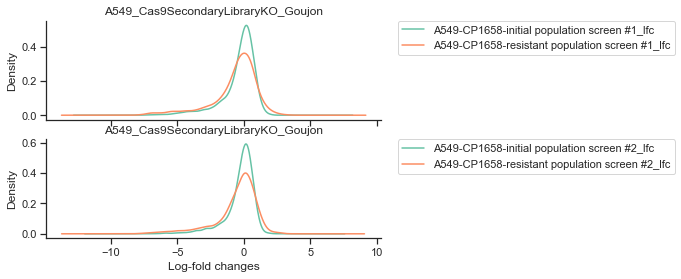

In [7]:
#Calculate log-fold change relative to pDNA
target_cols = list(lognorms.columns[3:])
pDNA_lfc = fns.calculate_lfc(lognorms,target_cols)
pDNA_lfc
pair1 = list(pDNA_lfc.columns[2:4])
pair2 = list(pDNA_lfc.columns[-2:])
paired_cols = (True, [pair1, pair2])
#Plot population distributions of log-fold changes 
fns.lfc_dist_plot(pDNA_lfc, paired_cols=paired_cols, filename = 'A549_Cas9SecondaryLibraryKO_Goujon')


### Distributions of control sets 

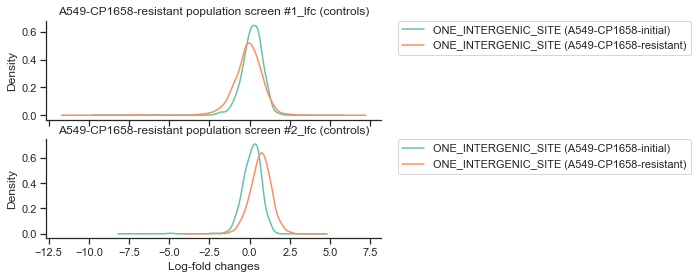

In [8]:
fns.control_dist_plot(pDNA_lfc, paired_cols=paired_cols, control_name=['ONE_INTERGENIC_SITE'], filename = 'A549_Cas9SecondaryLibraryKO_Goujon')


### ROC_AUC

Essential gene set: Hart et al., 2015 <br>
Non-essential gene set: Hart et al., 2014

Text(0, 0.5, 'True Positive Rate (essential)')

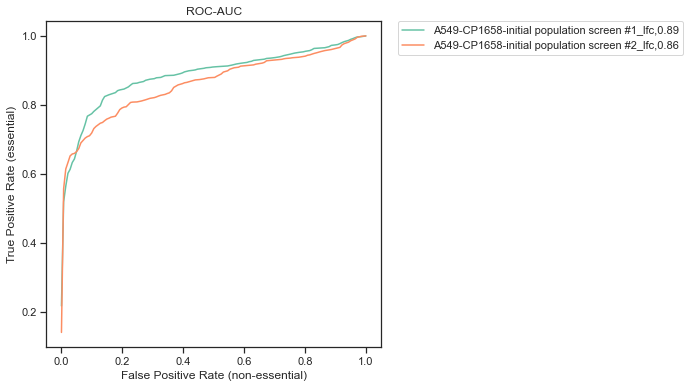

In [9]:
ess_genes, non_ess_genes = fns.get_gene_sets()
initial_cols = [col for col in pDNA_lfc.columns if 'initial' in col]

tp_genes = ess_genes.loc[:, 'Gene Symbol'].to_list()

fp_genes = non_ess_genes.loc[:, 'Gene Symbol'].to_list()

initial_roc_dict = {}
intial_roc_auc_dict = {}
for col in initial_cols:
    roc_auc, roc_df = pool.get_roc_aucs(pDNA_lfc, tp_genes, fp_genes, gene_col = 'Gene Symbol', score_col=col)
    initial_roc_dict[col] = roc_df
    intial_roc_auc_dict[col] = roc_auc

fig,ax=plt.subplots(figsize=(6,6))

for key, df in initial_roc_dict.items():
    roc_auc = intial_roc_auc_dict[key]
    ax=sns.lineplot(data=df, x='fpr',y='tpr', ci=None, label = key+',' + str(round(roc_auc,2)))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('ROC-AUC')
plt.xlabel('False Positive Rate (non-essential)')
plt.ylabel('True Positive Rate (essential)')


## Gene level analysis

### Residual z-scores

In [10]:
lfc_df = pDNA_lfc.drop('Gene Symbol', axis = 1)
lfc_df

,Construct Barcode,A549-CP1658-initial population screen #1_lfc,A549-CP1658-resistant population screen #1_lfc,A549-CP1658-initial population screen #2_lfc,A549-CP1658-resistant population screen #2_lfc
0,AAAAAAAATCTTGCTCAGGG,0.770865,1.029162,0.951536,0.959959
1,AAAAAATCGAACCATCTGAA,-0.003431,-0.768783,0.724719,-0.224385
2,AAAAAGCACTACCGTACCAT,-0.565543,-0.630659,0.020439,0.108337
3,AAAAATCCTCTGAAGCCGCA,-2.047476,-3.920603,-1.285772,-4.238680
4,AAAAATTGTAGGGCGCACCA,-5.159691,-6.769906,-3.848917,-6.891521
...,...,...,...,...,...
6277,TTTGTCCCTTCTTAAAAAAC,1.186981,1.279443,1.330180,0.948350
6278,TTTGTCCCTTCTTAAAAAAC,1.186981,1.279443,1.330180,0.948350
6279,TTTGTCGTGAAGATGCACAA,0.163930,0.078666,0.414022,0.891322
6280,TTTGTGCTCACCTACAAGCT,0.210163,-0.303211,-0.284114,-1.398938


In [11]:
# run_guide_residuals(lfc_df.drop_duplicates(), cols)
residuals_lfcs, all_model_info, model_fit_plots = run_guide_residuals(lfc_df, paired_lfc_cols=paired_cols[1])
residuals_lfcs


                                         modified  \
0  A549-CP1658-resistant population screen #1_lfc   
1  A549-CP1658-resistant population screen #2_lfc   

                                    unperturbed  
0  A549-CP1658-initial population screen #1_lfc  
1  A549-CP1658-initial population screen #2_lfc  


,Construct Barcode,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,AAAAAAAATCTTGCTCAGGG,A549-CP1658-resistant population screen #1_lfc,0.352928,0.424661,A549-CP1658-initial population screen #1_lfc,1.029162,0.770865
1,AAAAAATCGAACCATCTGAA,A549-CP1658-resistant population screen #1_lfc,-0.514704,-0.619318,A549-CP1658-initial population screen #1_lfc,-0.768783,-0.003431
2,AAAAAGCACTACCGTACCAT,A549-CP1658-resistant population screen #1_lfc,0.291686,0.350972,A549-CP1658-initial population screen #1_lfc,-0.630659,-0.565543
3,AAAAATCCTCTGAAGCCGCA,A549-CP1658-resistant population screen #1_lfc,-1.263413,-1.520203,A549-CP1658-initial population screen #1_lfc,-3.920603,-2.047476
4,AAAAATTGTAGGGCGCACCA,A549-CP1658-resistant population screen #1_lfc,-0.563754,-0.678338,A549-CP1658-initial population screen #1_lfc,-6.769906,-5.159691
...,...,...,...,...,...,...,...
12163,TTTGTCACTAAAGTGGACAA,A549-CP1658-resistant population screen #2_lfc,-0.065980,-0.086993,A549-CP1658-initial population screen #2_lfc,-1.413956,-0.874791
12164,TTTGTCCCTTCTTAAAAAAC,A549-CP1658-resistant population screen #2_lfc,-0.604635,-0.797189,A549-CP1658-initial population screen #2_lfc,0.948350,1.330180
12165,TTTGTCGTGAAGATGCACAA,A549-CP1658-resistant population screen #2_lfc,0.558608,0.736503,A549-CP1658-initial population screen #2_lfc,0.891322,0.414022
12166,TTTGTGCTCACCTACAAGCT,A549-CP1658-resistant population screen #2_lfc,-0.815445,-1.075133,A549-CP1658-initial population screen #2_lfc,-1.398938,-0.284114


In [12]:
guide_mapping = pool.group_pseudogenes(chip[['Construct Barcode', 'Gene Symbol']], pseudogene_size=10, gene_col='Gene Symbol', control_regex=['ONE_INTERGENIC_SITE'])
guide_mapping

,Construct Barcode,Gene Symbol
0,AAAAAAAATCTTGCTCAGGG,HYMAI
1,AAAAAATCGAACCATCTGAA,USP14
2,AAAAAGCACTACCGTACCAT,SLC26A7
3,AAAAATCCTCTGAAGCCGCA,TOP3A
4,AAAAATTGTAGGGCGCACCA,NCAPG
...,...,...
6277,TTTGTCCCTTCTTAAAAAAC,TXN
6278,TTTGTCCCTTCTTAAAAAAC,TXNP6
6279,TTTGTCGTGAAGATGCACAA,CREBBP
6280,TTTGTGCTCACCTACAAGCT,MFSD3


In [13]:
A549_gene_residuals = anchors.get_gene_residuals(residuals_lfcs.drop_duplicates(), guide_mapping)
A549_gene_residuals

,condition,Gene Symbol,guides,avg_lfc,avg_lfc_reference,residual_zscore,p_value,fdr_bh
0,A549-CP1658-resistant population screen #1_lfc,ACE2,10,-0.811360,-2.081903,7.056774,1.704119e-12,9.614071e-11
1,A549-CP1658-resistant population screen #1_lfc,ACR,10,-0.387121,0.113573,-1.041592,2.976008e-01,7.576329e-01
2,A549-CP1658-resistant population screen #1_lfc,ACTR2,10,-2.876554,-2.249752,0.008157,9.934916e-01,9.987865e-01
3,A549-CP1658-resistant population screen #1_lfc,ACTR3,10,-1.881187,-1.152860,-1.037491,2.995071e-01,7.576329e-01
4,A549-CP1658-resistant population screen #1_lfc,ADAM7,10,0.178744,0.417497,-0.279048,7.802080e-01,9.825798e-01
...,...,...,...,...,...,...,...,...
1349,A549-CP1658-resistant population screen #2_lfc,ZNF572,10,-0.081757,0.208411,-0.610941,5.412384e-01,8.454849e-01
1350,A549-CP1658-resistant population screen #2_lfc,ZNF594,10,-0.382711,-0.103528,-0.163102,8.704379e-01,9.828471e-01
1351,A549-CP1658-resistant population screen #2_lfc,ZNF7,10,-0.489521,-0.032093,-0.986939,3.236724e-01,6.869161e-01
1352,A549-CP1658-resistant population screen #2_lfc,ZNF703,10,0.199397,0.266560,0.214382,8.302494e-01,9.691014e-01


In [14]:
A549_gene_residual_sheet = fns.format_gene_residuals(A549_gene_residuals, guide_min = 8, guide_max = 11)

guide_residual_sheet = pd.merge(guide_mapping, residuals_lfcs.drop_duplicates(), on = 'Construct Barcode', how = 'inner')
guide_residual_sheet

['A549-CP1658-resistant population screen #1_lfc', 'A549-CP1658-resistant population screen #2_lfc']
A549-CP1658-resistant population screen #1_lfc
A549-CP1658-resistant population screen #2_lfc


,Construct Barcode,Gene Symbol,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,AAAAAAAATCTTGCTCAGGG,HYMAI,A549-CP1658-resistant population screen #1_lfc,0.352928,0.424661,A549-CP1658-initial population screen #1_lfc,1.029162,0.770865
1,AAAAAAAATCTTGCTCAGGG,HYMAI,A549-CP1658-resistant population screen #2_lfc,-0.086674,-0.114277,A549-CP1658-initial population screen #2_lfc,0.959959,0.951536
2,AAAAAATCGAACCATCTGAA,USP14,A549-CP1658-resistant population screen #1_lfc,-0.514704,-0.619318,A549-CP1658-initial population screen #1_lfc,-0.768783,-0.003431
3,AAAAAATCGAACCATCTGAA,USP14,A549-CP1658-resistant population screen #2_lfc,-0.968985,-1.277570,A549-CP1658-initial population screen #2_lfc,-0.224385,0.724719
4,AAAAAGCACTACCGTACCAT,SLC26A7,A549-CP1658-resistant population screen #1_lfc,0.291686,0.350972,A549-CP1658-initial population screen #1_lfc,-0.630659,-0.565543
...,...,...,...,...,...,...,...,...
12559,TTTGTCGTGAAGATGCACAA,CREBBP,A549-CP1658-resistant population screen #2_lfc,0.558608,0.736503,A549-CP1658-initial population screen #2_lfc,0.891322,0.414022
12560,TTTGTGCTCACCTACAAGCT,MFSD3,A549-CP1658-resistant population screen #1_lfc,-0.304689,-0.366617,A549-CP1658-initial population screen #1_lfc,-0.303211,0.210163
12561,TTTGTGCTCACCTACAAGCT,MFSD3,A549-CP1658-resistant population screen #2_lfc,-0.815445,-1.075133,A549-CP1658-initial population screen #2_lfc,-1.398938,-0.284114
12562,TTTGTGTTGATGAATCCTGG,IL1R1,A549-CP1658-resistant population screen #1_lfc,0.384063,0.462124,A549-CP1658-initial population screen #1_lfc,-0.528347,-0.557148


In [15]:
# with pd.ExcelWriter('../../../Data/Processed/GEO_submission_v2/SecondaryLibrary/A549_Cas9SecondaryLibraryKO_Goujon.xlsx') as writer:  
#     A549_gene_residual_sheet.to_excel(writer, sheet_name='A549_avg_zscore', index =False)
#     reads_A549.to_excel(writer, sheet_name='A549_genomewide_reads', index =False)
#     guide_mapping.to_excel(writer, sheet_name='A549_guide_mapping', index =False)

In [16]:
screen1_df = A549_gene_residuals[A549_gene_residuals['condition'].str.contains('#1')]
screen2_df = A549_gene_residuals[A549_gene_residuals['condition'].str.contains('#2')]
A549_zscore_df = pd.merge(screen1_df[['Gene Symbol', 'residual_zscore']], screen2_df[['Gene Symbol', 'residual_zscore']], on = 'Gene Symbol', how = 'outer', suffixes = ['_screen#1', '_screen#2'])
A549_zscore_df


,Gene Symbol,residual_zscore_screen#1,residual_zscore_screen#2
0,ACE2,7.056774,7.162055
1,ACR,-1.041592,-1.355842
2,ACTR2,0.008157,-0.733867
3,ACTR3,-1.037491,-0.735309
4,ADAM7,-0.279048,-0.085906
...,...,...,...
672,ZNF572,-0.641311,-0.610941
673,ZNF594,0.094078,-0.163102
674,ZNF7,-0.332027,-0.986939
675,ZNF703,0.745927,0.214382


####  Replicate Correlations

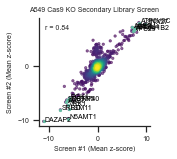

In [17]:
# Screen 2 vs Screen 1
fig, ax = plt.subplots(figsize = (2, 2))
ax = gpp.point_densityplot(A549_zscore_df, 'residual_zscore_screen#1', 'residual_zscore_screen#2', s=6)
ax = gpp.add_correlation(A549_zscore_df, 'residual_zscore_screen#1', 'residual_zscore_screen#2', fontsize=7)

top_ranked_screen1 = A549_zscore_df.nsmallest(10, 'residual_zscore_screen#1')
top_ranked_screen2 = A549_zscore_df.nsmallest(10, 'residual_zscore_screen#2')
bottom_ranked_screen1 = A549_zscore_df.nlargest(10, 'residual_zscore_screen#1')
bottom_ranked_screen2 = A549_zscore_df.nlargest(10, 'residual_zscore_screen#2')

screen1_ranked = pd.concat([top_ranked_screen1, bottom_ranked_screen1])
screen2_ranked = pd.concat([top_ranked_screen2, bottom_ranked_screen2])

# Annotate common hits
common_ranked = pd.merge(screen1_ranked, screen2_ranked, on = ['Gene Symbol', 'residual_zscore_screen#1', 'residual_zscore_screen#2'], how = 'inner')
common_ranked

sns.scatterplot(data=common_ranked, x='residual_zscore_screen#1', y='residual_zscore_screen#2', color = sns.color_palette('Set2')[0], edgecolor=None, s=6)

texts= []
for j, row in common_ranked.iterrows():
    texts.append(ax.text(row['residual_zscore_screen#1']+0.25, row['residual_zscore_screen#2'], row['Gene Symbol'], fontsize=7,
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)

plt.title('A549 Cas9 KO Secondary Library Screen', fontsize=7)
plt.xlabel('Screen #1 (Mean z-score)', fontsize=7)
plt.ylabel('Screen #2 (Mean z-score)', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
sns.despine()
# gpp.savefig('../../../Figures/Scatterplots/A549_Cas9KO_Secondary_Screen1vs2_scatterplot.pdf', dpi=300)



#### Primary vs secondary KO screens

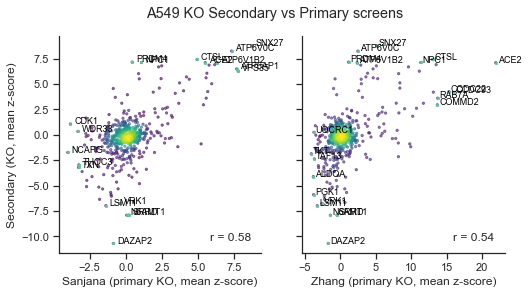

In [18]:
# Sanjana
Cas9_KO_A549_Sanjana_primary = pd.read_excel('../PrimaryScreens/Data/GSE175666_A549_GeCKOv2_Sanjana_v2.xlsx')

# Zhang
Cas9_KO_A549_Zhang_primary = pd.read_excel('../PrimaryScreens/Data/GSE175666_A549_Brunello_Zhang.xlsx')

Cas9_KO_A549_primary = pd.merge(Cas9_KO_A549_Sanjana_primary, Cas9_KO_A549_Zhang_primary, on = 'Gene Symbol', how = 'outer')
Cas9_KO_A549_primary = Cas9_KO_A549_primary.rename(columns = {'residual_zscore_avg':'residual_zscore_avg_Sanjana',
                                                  'Rank_residual_zscore_avg':'Rank_residual_zscore_avg_Sanjana',
                                                  'residual_zscore':'residual_zscore_Zhang',
                                                  'Rank_residual_zscore':'Rank_residual_zscore_Zhang'})

primaryvssecondary_A549 = pd.merge(Cas9_KO_A549_primary, A549_gene_residual_sheet, on = 'Gene Symbol', how = 'inner')
primaryvssecondary_A549 = primaryvssecondary_A549.rename(columns={'residual_zscore_avg':'residual_zscore_avg_SecondaryKO',
                                                                 'Rank_residual_zscore_avg':'Rank_residual_zscore_avg_SecondaryKO'})

fig, axs = plt.subplots(ncols = 2, figsize = (8, 4), sharey=True)
axs[0] = gpp.point_densityplot(primaryvssecondary_A549.dropna(), 'residual_zscore_avg_Sanjana', 'residual_zscore_avg_SecondaryKO', s=6, ax = axs[0])
axs[0] = gpp.add_correlation(primaryvssecondary_A549.dropna(), 'residual_zscore_avg_Sanjana', 'residual_zscore_avg_SecondaryKO', loc = 'lower right', ax = axs[0])

axs[1] = gpp.point_densityplot(primaryvssecondary_A549.dropna(), 'residual_zscore_Zhang', 'residual_zscore_avg_SecondaryKO', s=6, ax = axs[1])
axs[1] = gpp.add_correlation(primaryvssecondary_A549.dropna(), 'residual_zscore_Zhang', 'residual_zscore_avg_SecondaryKO', loc = 'lower right', ax = axs[1])

top_ranked_Sanjana = primaryvssecondary_A549.nlargest(5, 'residual_zscore_avg_Sanjana')
bottom_ranked_Sanjana = primaryvssecondary_A549.nsmallest(5, 'residual_zscore_avg_Sanjana')
top_ranked_Zhang = primaryvssecondary_A549.nlargest(5, 'residual_zscore_Zhang')
bottom_ranked_Zhang = primaryvssecondary_A549.nsmallest(5, 'residual_zscore_Zhang')
top_ranked_SecondaryKO = primaryvssecondary_A549.nlargest(7, 'residual_zscore_avg_SecondaryKO')
bottom_ranked_SecondaryKO = primaryvssecondary_A549.nsmallest(5, 'residual_zscore_avg_SecondaryKO')

Sanjana_ranked = pd.concat([top_ranked_Sanjana, bottom_ranked_Sanjana])
Zhang_ranked = pd.concat([top_ranked_Zhang, bottom_ranked_Zhang])
SecondaryKO_ranked = pd.concat([top_ranked_SecondaryKO, bottom_ranked_SecondaryKO])

# Annotate hits
annot_df_Sanjana = pd.concat([Sanjana_ranked, SecondaryKO_ranked]).drop_duplicates()
sns.scatterplot(data=annot_df_Sanjana, x='residual_zscore_avg_Sanjana', y='residual_zscore_avg_SecondaryKO', color = sns.color_palette('Set2')[0], edgecolor=None, s=6, ax=axs[0])

texts= []
for j, row in annot_df_Sanjana.iterrows():
    texts.append(axs[0].text(row['residual_zscore_avg_Sanjana']+0.25, row['residual_zscore_avg_SecondaryKO'], row['Gene Symbol'], fontsize=9,
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)

axs[0].set_xlabel('Sanjana (primary KO, mean z-score)')
axs[0].set_ylabel('Secondary (KO, mean z-score)')


annot_df_Zhang = pd.concat([Zhang_ranked, SecondaryKO_ranked]).drop_duplicates()
sns.scatterplot(data=annot_df_Zhang, x='residual_zscore_Zhang', y='residual_zscore_avg_SecondaryKO', color = sns.color_palette('Set2')[0], edgecolor=None, s=6, ax=axs[1])

texts= []
for j, row in annot_df_Zhang.iterrows():
    texts.append(axs[1].text(row['residual_zscore_Zhang']+0.25, row['residual_zscore_avg_SecondaryKO'], row['Gene Symbol'], fontsize=9,
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)

axs[1].set_xlabel('Zhang (primary KO, mean z-score)')
axs[1].set_ylabel('Secondary (KO, mean z-score)')


plt.suptitle('A549 KO Secondary vs Primary screens')

sns.despine()
# gpp.savefig('../../../Figures/Scatterplots/A549_KOPrimaryvsKOSecondary_scatterplot.pdf', dpi=300)




In [20]:
# with pd.ExcelWriter('../../../Data/Processed/Individual_screens_v2/A549_Cas9SecondaryLibraryKO_Goujon_indiv_screens.xlsx') as writer:  
#     A549_zscore_df.to_excel(writer, sheet_name='indiv_screen_zscore', index =False)
#     A549_gene_residuals.to_excel(writer, sheet_name='condition_genomewide_zscore', index =False)
#     guide_residual_sheet.to_excel(writer, sheet_name='guide-level_zscore', index =False)

# Huh-7.5.1

## Data summary
 

In [19]:
# Reads from Supplemental File 9
reads_Huh751 = pd.read_excel('Data/GSE193834_Supplemental_File_9_Huh7.5.1-ACE2_KO_SecondaryLibrary_Goujon.xlsx', sheet_name = 'Huh751_genomewide_reads')
reads_Huh751



,Construct Barcode,pDNA,Huh751-CP1658-initial population screen #1,Huh751-CP1658-resistant population screen #1,Huh751-CP1658-initial population screen #2,Huh751-CP1658-resistant population screen #2
0,AAAAAAAATCTTGCTCAGGG,80,2611,7614,3997,3062
1,AAAAAATCGAACCATCTGAA,58,1685,1186,1772,1478
2,AAAAAGCACTACCGTACCAT,51,1633,644,1068,621
3,AAAAATCCTCTGAAGCCGCA,67,661,2,996,80
4,AAAAATTGTAGGGCGCACCA,61,585,0,732,53
...,...,...,...,...,...,...
6079,TTTGTCACTAAAGTGGACAA,66,2619,1056,2602,1690
6080,TTTGTCCCTTCTTAAAAAAC,30,1102,363,3031,2595
6081,TTTGTCGTGAAGATGCACAA,65,2042,5554,1913,1903
6082,TTTGTGCTCACCTACAAGCT,31,1733,1049,1658,1065


In [20]:
# Gene Annotations

# Gene Annotations
chip = pd.read_excel('Data/GSE193834_Supplemental_File_9_Huh7.5.1-ACE2_KO_SecondaryLibrary_Goujon.xlsx', sheet_name = 'Huh751_guide_mapping')
# Merge annotations with reads
chip_reads_Huh751 = pd.merge(chip[['Construct Barcode', 'Gene Symbol']], reads_Huh751, on = ['Construct Barcode'], how = 'right')
chip_reads_Huh751


,Construct Barcode,Gene Symbol,pDNA,Huh751-CP1658-initial population screen #1,Huh751-CP1658-resistant population screen #1,Huh751-CP1658-initial population screen #2,Huh751-CP1658-resistant population screen #2
0,AAAAAAAATCTTGCTCAGGG,HYMAI,80,2611,7614,3997,3062
1,AAAAAATCGAACCATCTGAA,USP14,58,1685,1186,1772,1478
2,AAAAAGCACTACCGTACCAT,SLC26A7,51,1633,644,1068,621
3,AAAAATCCTCTGAAGCCGCA,TOP3A,67,661,2,996,80
4,AAAAATTGTAGGGCGCACCA,NCAPG,61,585,0,732,53
...,...,...,...,...,...,...,...
6277,TTTGTCCCTTCTTAAAAAAC,TXN,30,1102,363,3031,2595
6278,TTTGTCCCTTCTTAAAAAAC,TXNP6,30,1102,363,3031,2595
6279,TTTGTCGTGAAGATGCACAA,CREBBP,65,2042,5554,1913,1903
6280,TTTGTGCTCACCTACAAGCT,MFSD3,31,1733,1049,1658,1065


In [21]:
#Calculate lognorm
cols = chip_reads_Huh751.columns[2:].to_list() #reads columns = start at 3rd column
lognorms = fns.get_lognorm(chip_reads_Huh751.dropna(), cols = cols)
col_list = []

for col in lognorms.columns:
    if 'intitial'in col:
        new_col = col.replace('intitial', 'initial')
        col_list.append(new_col)
    else:
        col_list.append(col)

lognorms.columns = col_list
lognorms

,Construct Barcode,Gene Symbol,pDNA_lognorm,Huh751-CP1658-initial population screen #1_lognorm,Huh751-CP1658-resistant population screen #1_lognorm,Huh751-CP1658-initial population screen #2_lognorm,Huh751-CP1658-resistant population screen #2_lognorm
0,AAAAAAAATCTTGCTCAGGG,HYMAI,7.727405,7.309437,8.484592,7.754902,7.537769
1,AAAAAATCGAACCATCTGAA,USP14,7.266038,6.682573,5.823707,6.589726,6.495237
2,AAAAAGCACTACCGTACCAT,SLC26A7,7.081768,6.637797,4.964016,5.869099,5.266159
3,AAAAATCCTCTGAAGCCGCA,TOP3A,7.472887,5.354142,0.129382,5.770188,2.543189
4,AAAAATTGTAGGGCGCACCA,NCAPG,7.338333,5.182504,0.000000,5.335388,2.070065
...,...,...,...,...,...,...,...
6277,TTTGTCCCTTCTTAAAAAAC,TXN,6.323669,6.077360,4.172270,7.357906,7.300425
6278,TTTGTCCCTTCTTAAAAAAC,TXNP6,6.323669,6.077360,4.172270,7.357906,7.300425
6279,TTTGTCGTGAAGATGCACAA,CREBBP,7.429415,6.957350,8.030957,6.699080,6.856291
6280,TTTGTGCTCACCTACAAGCT,MFSD3,6.370394,6.722707,5.649941,6.494821,6.028633


## Quality Control
### Population Distributions

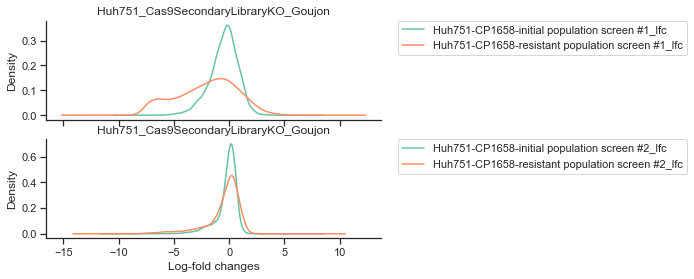

In [22]:
#Calculate log-fold change relative to pDNA
target_cols = list(lognorms.columns[3:])
pDNA_lfc = fns.calculate_lfc(lognorms,target_cols)
pDNA_lfc
pair1 = list(pDNA_lfc.columns[2:4])
pair2 = list(pDNA_lfc.columns[-2:])
paired_cols = (True, [pair1, pair2])
#Plot population distributions of log-fold changes 
fns.lfc_dist_plot(pDNA_lfc, paired_cols=paired_cols, filename = 'Huh751_Cas9SecondaryLibraryKO_Goujon')


### Distributions of control sets 

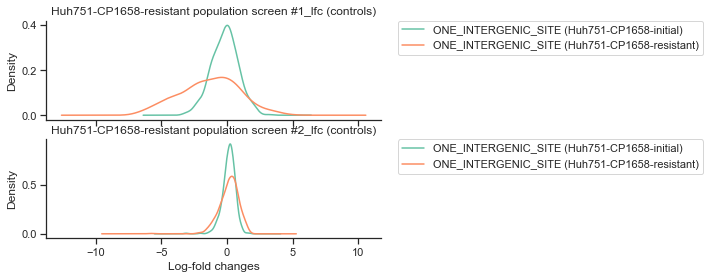

In [23]:
fns.control_dist_plot(pDNA_lfc, paired_cols=paired_cols, control_name=['ONE_INTERGENIC_SITE'], filename = 'Huh751_Cas9SecondaryLibraryKO_Goujon')


### ROC_AUC

Essential gene set: Hart et al., 2015 <br>
Non-essential gene set: Hart et al., 2014

Text(0, 0.5, 'True Positive Rate (essential)')

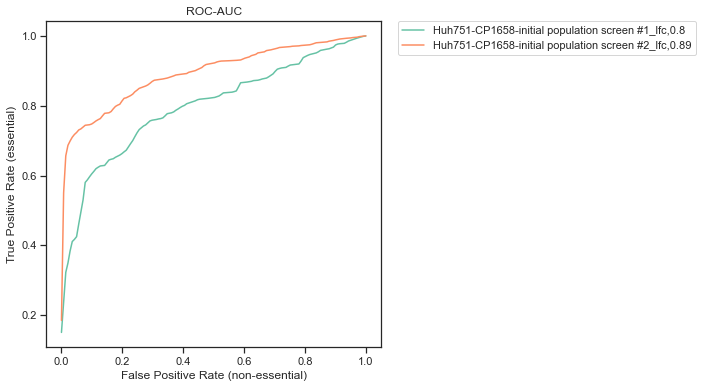

In [24]:
ess_genes, non_ess_genes = fns.get_gene_sets()
initial_cols = [col for col in pDNA_lfc.columns if 'initial' in col]

tp_genes = ess_genes.loc[:, 'Gene Symbol'].to_list()

fp_genes = non_ess_genes.loc[:, 'Gene Symbol'].to_list()

initial_roc_dict = {}
intial_roc_auc_dict = {}
for col in initial_cols:
    roc_auc, roc_df = pool.get_roc_aucs(pDNA_lfc, tp_genes, fp_genes, gene_col = 'Gene Symbol', score_col=col)
    initial_roc_dict[col] = roc_df
    intial_roc_auc_dict[col] = roc_auc

fig,ax=plt.subplots(figsize=(6,6))

for key, df in initial_roc_dict.items():
    roc_auc = intial_roc_auc_dict[key]
    ax=sns.lineplot(data=df, x='fpr',y='tpr', ci=None, label = key+',' + str(round(roc_auc,2)))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('ROC-AUC')
plt.xlabel('False Positive Rate (non-essential)')
plt.ylabel('True Positive Rate (essential)')


## Gene level analysis

### Residual z-scores

In [25]:
lfc_df = pDNA_lfc.drop('Gene Symbol', axis = 1)
lfc_df

,Construct Barcode,Huh751-CP1658-initial population screen #1_lfc,Huh751-CP1658-resistant population screen #1_lfc,Huh751-CP1658-initial population screen #2_lfc,Huh751-CP1658-resistant population screen #2_lfc
0,AAAAAAAATCTTGCTCAGGG,-0.417968,0.757186,0.027497,-0.189637
1,AAAAAATCGAACCATCTGAA,-0.583465,-1.442331,-0.676312,-0.770801
2,AAAAAGCACTACCGTACCAT,-0.443972,-2.117752,-1.212670,-1.815609
3,AAAAATCCTCTGAAGCCGCA,-2.118744,-7.343504,-1.702699,-4.929697
4,AAAAATTGTAGGGCGCACCA,-2.155830,-7.338333,-2.002945,-5.268269
...,...,...,...,...,...
6277,TTTGTCCCTTCTTAAAAAAC,-0.246309,-2.151400,1.034236,0.976756
6278,TTTGTCCCTTCTTAAAAAAC,-0.246309,-2.151400,1.034236,0.976756
6279,TTTGTCGTGAAGATGCACAA,-0.472065,0.601542,-0.730336,-0.573124
6280,TTTGTGCTCACCTACAAGCT,0.352313,-0.720453,0.124427,-0.341761


In [26]:
# run_guide_residuals(lfc_df.drop_duplicates(), cols)
residuals_lfcs, all_model_info, model_fit_plots = run_guide_residuals(lfc_df, paired_lfc_cols=paired_cols[1])
residuals_lfcs


                                           modified  \
0  Huh751-CP1658-resistant population screen #1_lfc   
1  Huh751-CP1658-resistant population screen #2_lfc   

                                      unperturbed  
0  Huh751-CP1658-initial population screen #1_lfc  
1  Huh751-CP1658-initial population screen #2_lfc  


,Construct Barcode,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,AAAAAAAATCTTGCTCAGGG,Huh751-CP1658-resistant population screen #1_lfc,2.705506,1.757780,Huh751-CP1658-initial population screen #1_lfc,0.757186,-0.417968
1,AAAAAATCGAACCATCTGAA,Huh751-CP1658-resistant population screen #1_lfc,0.824008,0.535362,Huh751-CP1658-initial population screen #1_lfc,-1.442331,-0.583465
2,AAAAAGCACTACCGTACCAT,Huh751-CP1658-resistant population screen #1_lfc,-0.119695,-0.077766,Huh751-CP1658-initial population screen #1_lfc,-2.117752,-0.443972
3,AAAAATCCTCTGAAGCCGCA,Huh751-CP1658-resistant population screen #1_lfc,-1.963504,-1.275698,Huh751-CP1658-initial population screen #1_lfc,-7.343504,-2.118744
4,AAAAATTGTAGGGCGCACCA,Huh751-CP1658-resistant population screen #1_lfc,-1.895103,-1.231257,Huh751-CP1658-initial population screen #1_lfc,-7.338333,-2.155830
...,...,...,...,...,...,...,...
12163,TTTGTCACTAAAGTGGACAA,Huh751-CP1658-resistant population screen #2_lfc,-0.094322,-0.139951,Huh751-CP1658-initial population screen #2_lfc,-0.764708,-0.312132
12164,TTTGTCCCTTCTTAAAAAAC,Huh751-CP1658-resistant population screen #2_lfc,-0.407907,-0.605233,Huh751-CP1658-initial population screen #2_lfc,0.976756,1.034236
12165,TTTGTCGTGAAGATGCACAA,Huh751-CP1658-resistant population screen #2_lfc,0.727322,1.079168,Huh751-CP1658-initial population screen #2_lfc,-0.573124,-0.730336
12166,TTTGTGCTCACCTACAAGCT,Huh751-CP1658-resistant population screen #2_lfc,-0.333332,-0.494582,Huh751-CP1658-initial population screen #2_lfc,-0.341761,0.124427


In [27]:
guide_mapping = pool.group_pseudogenes(chip[['Construct Barcode', 'Gene Symbol']], pseudogene_size=10, gene_col='Gene Symbol', control_regex=['ONE_INTERGENIC_SITE'])
guide_mapping

,Construct Barcode,Gene Symbol
0,AAAAAAAATCTTGCTCAGGG,HYMAI
1,AAAAAATCGAACCATCTGAA,USP14
2,AAAAAGCACTACCGTACCAT,SLC26A7
3,AAAAATCCTCTGAAGCCGCA,TOP3A
4,AAAAATTGTAGGGCGCACCA,NCAPG
...,...,...
6277,TTTGTCCCTTCTTAAAAAAC,TXN
6278,TTTGTCCCTTCTTAAAAAAC,TXNP6
6279,TTTGTCGTGAAGATGCACAA,CREBBP
6280,TTTGTGCTCACCTACAAGCT,MFSD3


In [28]:
Huh751_gene_residuals = anchors.get_gene_residuals(residuals_lfcs.drop_duplicates(), guide_mapping)
Huh751_gene_residuals

,condition,Gene Symbol,guides,avg_lfc,avg_lfc_reference,residual_zscore,p_value,fdr_bh
0,Huh751-CP1658-resistant population screen #1_lfc,ACE2,10,-1.321225,-1.273579,4.346661,0.000014,0.001337
1,Huh751-CP1658-resistant population screen #1_lfc,ACR,10,-1.549527,-0.096526,-0.371474,0.710284,0.935196
2,Huh751-CP1658-resistant population screen #1_lfc,ACTR2,10,-4.630675,-1.489877,-1.227782,0.219529,0.712514
3,Huh751-CP1658-resistant population screen #1_lfc,ACTR3,10,-2.748293,-1.020053,0.922584,0.356224,0.782687
4,Huh751-CP1658-resistant population screen #1_lfc,ADAM7,10,0.613972,0.758941,1.003185,0.315772,0.781433
...,...,...,...,...,...,...,...,...
1349,Huh751-CP1658-resistant population screen #2_lfc,ZNF572,10,0.513409,0.501610,-0.254586,0.799043,0.960379
1350,Huh751-CP1658-resistant population screen #2_lfc,ZNF594,10,0.020832,-0.057105,1.420406,0.155490,0.548263
1351,Huh751-CP1658-resistant population screen #2_lfc,ZNF7,10,0.338789,0.299940,0.367861,0.712977,0.931928
1352,Huh751-CP1658-resistant population screen #2_lfc,ZNF703,10,0.184199,0.175553,0.531245,0.595249,0.905581


In [29]:
Huh751_gene_residual_sheet = fns.format_gene_residuals(Huh751_gene_residuals, guide_min = 8, guide_max = 11)

guide_residual_sheet = pd.merge(guide_mapping, residuals_lfcs.drop_duplicates(), on = 'Construct Barcode', how = 'inner')
guide_residual_sheet

['Huh751-CP1658-resistant population screen #2_lfc', 'Huh751-CP1658-resistant population screen #1_lfc']
Huh751-CP1658-resistant population screen #2_lfc
Huh751-CP1658-resistant population screen #1_lfc


,Construct Barcode,Gene Symbol,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,AAAAAAAATCTTGCTCAGGG,HYMAI,Huh751-CP1658-resistant population screen #1_lfc,2.705506,1.757780,Huh751-CP1658-initial population screen #1_lfc,0.757186,-0.417968
1,AAAAAAAATCTTGCTCAGGG,HYMAI,Huh751-CP1658-resistant population screen #2_lfc,-0.033844,-0.050216,Huh751-CP1658-initial population screen #2_lfc,-0.189637,0.027497
2,AAAAAATCGAACCATCTGAA,USP14,Huh751-CP1658-resistant population screen #1_lfc,0.824008,0.535362,Huh751-CP1658-initial population screen #1_lfc,-1.442331,-0.583465
3,AAAAAATCGAACCATCTGAA,USP14,Huh751-CP1658-resistant population screen #2_lfc,0.448469,0.665419,Huh751-CP1658-initial population screen #2_lfc,-0.770801,-0.676312
4,AAAAAGCACTACCGTACCAT,SLC26A7,Huh751-CP1658-resistant population screen #1_lfc,-0.119695,-0.077766,Huh751-CP1658-initial population screen #1_lfc,-2.117752,-0.443972
...,...,...,...,...,...,...,...,...
12559,TTTGTCGTGAAGATGCACAA,CREBBP,Huh751-CP1658-resistant population screen #2_lfc,0.727322,1.079168,Huh751-CP1658-initial population screen #2_lfc,-0.573124,-0.730336
12560,TTTGTGCTCACCTACAAGCT,MFSD3,Huh751-CP1658-resistant population screen #1_lfc,-0.254938,-0.165635,Huh751-CP1658-initial population screen #1_lfc,-0.720453,0.352313
12561,TTTGTGCTCACCTACAAGCT,MFSD3,Huh751-CP1658-resistant population screen #2_lfc,-0.333332,-0.494582,Huh751-CP1658-initial population screen #2_lfc,-0.341761,0.124427
12562,TTTGTGTTGATGAATCCTGG,IL1R1,Huh751-CP1658-resistant population screen #1_lfc,1.324378,0.860454,Huh751-CP1658-initial population screen #1_lfc,1.014519,0.450205


In [38]:
# with pd.ExcelWriter('../../../Data/Processed/GEO_submission_v2/SecondaryLibrary/Huh751_Cas9SecondaryLibraryKO_Goujon.xlsx') as writer:  
#     Huh751_gene_residual_sheet.to_excel(writer, sheet_name='Huh751_avg_zscore', index =False)
#     reads_Huh751.to_excel(writer, sheet_name='Huh751_genomewide_reads', index =False)
#     guide_mapping.to_excel(writer, sheet_name='Huh751_guide_mapping', index =False)

#### Replicate Correlations

In [30]:
screen1_df = Huh751_gene_residuals[Huh751_gene_residuals['condition'].str.contains('#1')]
screen2_df = Huh751_gene_residuals[Huh751_gene_residuals['condition'].str.contains('#2')]
zscore_df = pd.merge(screen1_df[['Gene Symbol', 'residual_zscore']], screen2_df[['Gene Symbol', 'residual_zscore']], on = 'Gene Symbol', how = 'outer', suffixes = ['_screen#1', '_screen#2'])
zscore_df

,Gene Symbol,residual_zscore_screen#1,residual_zscore_screen#2
0,ACE2,4.346661,7.804739
1,ACR,-0.371474,0.515719
2,ACTR2,-1.227782,1.154878
3,ACTR3,0.922584,1.961400
4,ADAM7,1.003185,-0.490591
...,...,...,...
672,ZNF572,-0.119235,-0.254586
673,ZNF594,0.106960,1.420406
674,ZNF7,1.239481,0.367861
675,ZNF703,-0.457388,0.531245


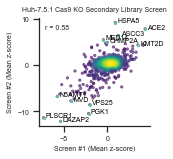

In [32]:
# Screen 2 vs Screen 1
fig, ax = plt.subplots(figsize = (2, 2))
ax = gpp.point_densityplot(zscore_df, 'residual_zscore_screen#1', 'residual_zscore_screen#2', s=6)
ax = gpp.add_correlation(zscore_df, 'residual_zscore_screen#1', 'residual_zscore_screen#2', fontsize=7)

top_ranked_screen1 = zscore_df.nlargest(10, 'residual_zscore_screen#1')
top_ranked_screen2 = zscore_df.nlargest(10, 'residual_zscore_screen#2')
bottom_ranked_screen1 = zscore_df.nsmallest(10, 'residual_zscore_screen#1')
bottom_ranked_screen2 = zscore_df.nsmallest(10, 'residual_zscore_screen#2')

screen1_ranked = pd.concat([top_ranked_screen1, bottom_ranked_screen1])
screen2_ranked = pd.concat([top_ranked_screen2, bottom_ranked_screen2])

# Annotate common hits
common_ranked = pd.merge(screen1_ranked, screen2_ranked, on = ['Gene Symbol', 'residual_zscore_screen#1', 'residual_zscore_screen#2'], how = 'inner')
common_ranked
annot_df = pd.concat([common_ranked, top_ranked_screen2.head(5), bottom_ranked_screen2.head(5)]).drop_duplicates()

sns.scatterplot(data=annot_df, x='residual_zscore_screen#1', y='residual_zscore_screen#2', color = sns.color_palette('Set2')[0], edgecolor=None, s=6)

texts= []
for j, row in annot_df.iterrows():
    texts.append(ax.text(row['residual_zscore_screen#1']+0.25, row['residual_zscore_screen#2'], row['Gene Symbol'], fontsize=7,
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)

plt.title('Huh-7.5.1 Cas9 KO Secondary Library Screen', fontsize=7)
plt.xlabel('Screen #1 (Mean z-score)', fontsize=7)
plt.ylabel('Screen #2 (Mean z-score)', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
sns.despine()
# gpp.savefig('../../../Figures/Scatterplots/Huh751_Cas9KO_Secondary_Screen1vs2_scatterplot.pdf', dpi=300)



In [33]:
def rep_corr_scatterplot(df, col1, col2, title, filename):
    
    fig, ax = plt.subplots(figsize = (2, 2))
    ax = gpp.point_densityplot(df, col1, col2, s=6)
    ax = gpp.add_correlation(df, col1, col2, fontsize=7)

    top_ranked_screen1 = df.nlargest(10, col1)
    top_ranked_screen2 = df.nlargest(10, col2)
    bottom_ranked_screen1 = df.nsmallest(10, col1)
    bottom_ranked_screen2 = df.nsmallest(10, col2)

    screen1_ranked = pd.concat([top_ranked_screen1, bottom_ranked_screen1])
    screen2_ranked = pd.concat([top_ranked_screen2, bottom_ranked_screen2])

    # Annotate common hits
    common_ranked = pd.merge(screen1_ranked, screen2_ranked, on = ['Gene Symbol', col1, col2], how = 'inner')
    common_ranked
    annot_df = pd.concat([common_ranked, top_ranked_screen2.head(5), bottom_ranked_screen2.head(5)]).drop_duplicates()

    sns.scatterplot(data=annot_df, x=col1, y=col2, color = sns.color_palette('Set2')[0], edgecolor=None, s=6)

    texts= []
    for j, row in annot_df.iterrows():
        texts.append(ax.text(row[col1]+0.25, row[col2], row['Gene Symbol'], fontsize=7,
                                      color = 'black'))
            # ensures text labels are non-overlapping
    #     adjust_text(texts)

    plt.title(title, fontsize=7)
    plt.xlabel('Screen #1 (Mean z-score)', fontsize=7)
    plt.ylabel('Screen #2 (Mean z-score)', fontsize=7)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    sns.despine()
#     gpp.savefig('../../../Figures/Scatterplots/'+filename+'.pdf', dpi=300)



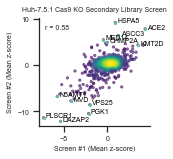

In [34]:
rep_corr_scatterplot(zscore_df, 'residual_zscore_screen#1', 'residual_zscore_screen#2', title='Huh-7.5.1 Cas9 KO Secondary Library Screen', filename='Huh751_Cas9KO_Secondary_Screen1vs2_scatterplot')



In [41]:
# with pd.ExcelWriter('../../../Data/Processed/Individual_screens_v2/Huh751_Cas9SecondaryLibraryKO_Goujon_indiv_screens.xlsx') as writer:  
#     zscore_df.to_excel(writer, sheet_name='indiv_screen_zscore', index =False)
#     Huh751_gene_residuals.to_excel(writer, sheet_name='condition_genomewide_zscore', index =False)
#     guide_residual_sheet.to_excel(writer, sheet_name='guide-level_zscore', index =False)

#### Primary vs secondary KO screens

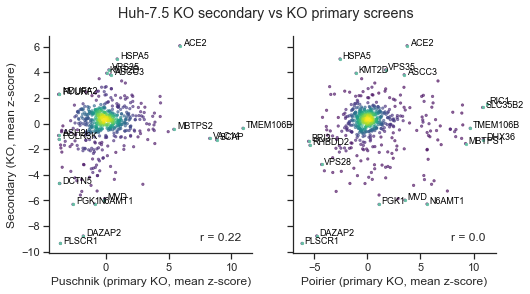

In [35]:
Cas9_KO_Huh7_5_Puschnik_primary = pd.read_excel('../PrimaryScreens/Data/GSE175666_Huh751_GeCKOv2_Puschnik.xlsx')
Cas9_KO_Huh7_5_Poirier_primary = pd.read_excel('../PrimaryScreens/Data/GSE175666_Huh75_Brunello_Poirier_v2.xlsx')

Cas9_KO_Huh7_5_primary = pd.merge(Cas9_KO_Huh7_5_Puschnik_primary, Cas9_KO_Huh7_5_Poirier_primary, on = 'Gene Symbol', how = 'outer')

Cas9_KO_Huh7_5_primary = Cas9_KO_Huh7_5_primary.rename(columns = {'residual_zscore':'residual_zscore_Puschnik',
                                                  'Rank_residual_zscore':'Rank_residual_zscore_Puschnik',
                                                  'residual_zscore_avg':'residual_zscore_avg_Poirier',
                                                  'Rank_residual_zscore_avg':'Rank_residual_zscore_avg_Poirier'})

primaryvssecondary_Huh7_5 = pd.merge(Cas9_KO_Huh7_5_primary, Huh751_gene_residual_sheet, on = 'Gene Symbol', how = 'inner')
primaryvssecondary_Huh7_5
primaryvssecondary_Huh7_5 = primaryvssecondary_Huh7_5.rename(columns={'residual_zscore_avg':'residual_zscore_avg_SecondaryKO',
                                                                 'Rank_residual_zscore_avg':'Rank_residual_zscore_avg_SecondaryKO'})

fig, axs = plt.subplots(ncols = 2, figsize = (8, 4), sharey=True)
axs[0] = gpp.point_densityplot(primaryvssecondary_Huh7_5.dropna(), 'residual_zscore_Puschnik', 'residual_zscore_avg_SecondaryKO', s=6, ax = axs[0])
axs[0] = gpp.add_correlation(primaryvssecondary_Huh7_5.dropna(), 'residual_zscore_Puschnik', 'residual_zscore_avg_SecondaryKO', loc = 'lower right', ax = axs[0])

axs[1] = gpp.point_densityplot(primaryvssecondary_Huh7_5.dropna(), 'residual_zscore_avg_Poirier', 'residual_zscore_avg_SecondaryKO', s=6, ax = axs[1])
axs[1] = gpp.add_correlation(primaryvssecondary_Huh7_5.dropna(), 'residual_zscore_avg_Poirier', 'residual_zscore_avg_SecondaryKO', loc = 'lower right', ax = axs[1])

top_ranked_Puschnik = primaryvssecondary_Huh7_5.nlargest(5, 'residual_zscore_Puschnik')
bottom_ranked_Puschnik = primaryvssecondary_Huh7_5.nsmallest(5, 'residual_zscore_Puschnik')
top_ranked_Poirier = primaryvssecondary_Huh7_5.nlargest(5, 'residual_zscore_avg_Poirier')
bottom_ranked_Poirier = primaryvssecondary_Huh7_5.nsmallest(5, 'residual_zscore_avg_Poirier')
top_ranked_SecondaryKO = primaryvssecondary_Huh7_5.nlargest(5, 'residual_zscore_avg_SecondaryKO')
bottom_ranked_SecondaryKO = primaryvssecondary_Huh7_5.nsmallest(5, 'residual_zscore_avg_SecondaryKO')

Puschnik_ranked = pd.concat([top_ranked_Puschnik, bottom_ranked_Puschnik])
Poirier_ranked = pd.concat([top_ranked_Poirier, bottom_ranked_Poirier])
SecondaryKO_ranked = pd.concat([top_ranked_SecondaryKO, bottom_ranked_SecondaryKO])

# Annotate hits
annot_df_Puschnik = pd.concat([Puschnik_ranked, SecondaryKO_ranked]).drop_duplicates()
sns.scatterplot(data=annot_df_Puschnik, x='residual_zscore_Puschnik', y='residual_zscore_avg_SecondaryKO', color = sns.color_palette('Set2')[0], edgecolor=None, s=6, ax=axs[0])

texts= []
for j, row in annot_df_Puschnik.iterrows():
    texts.append(axs[0].text(row['residual_zscore_Puschnik']+0.25, row['residual_zscore_avg_SecondaryKO'], row['Gene Symbol'], fontsize=9,
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)

annot_df_Poirier = pd.concat([Poirier_ranked, SecondaryKO_ranked]).drop_duplicates()
sns.scatterplot(data=annot_df_Poirier, x='residual_zscore_avg_Poirier', y='residual_zscore_avg_SecondaryKO', color = sns.color_palette('Set2')[0], edgecolor=None, s=6, ax=axs[1])

axs[0].set_xlabel('Puschnik (primary KO, mean z-score)')
axs[0].set_ylabel('Secondary (KO, mean z-score)')


texts= []
for j, row in annot_df_Poirier.iterrows():
    texts.append(axs[1].text(row['residual_zscore_avg_Poirier']+0.25, row['residual_zscore_avg_SecondaryKO'], row['Gene Symbol'], fontsize=9,
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)

axs[1].set_xlabel('Poirier (primary KO, mean z-score)')
axs[1].set_ylabel('Secondary (KO, mean z-score)')

plt.suptitle('Huh-7.5 KO secondary vs KO primary screens')
sns.despine()
# # fig.savefig('../../../Figures/Scatterplots/Calu3_KO_Cas9PrimaryvsCas12aSecondary_scatterplot.png', bbox_inches = 'tight', dpi=300)
# gpp.savefig('../../../Figures/Scatterplots/Huh7_5_KOPrimaryvsKOSecondary_scatterplot.pdf', dpi=300)




## Secondary Cas9 KO screen comparison

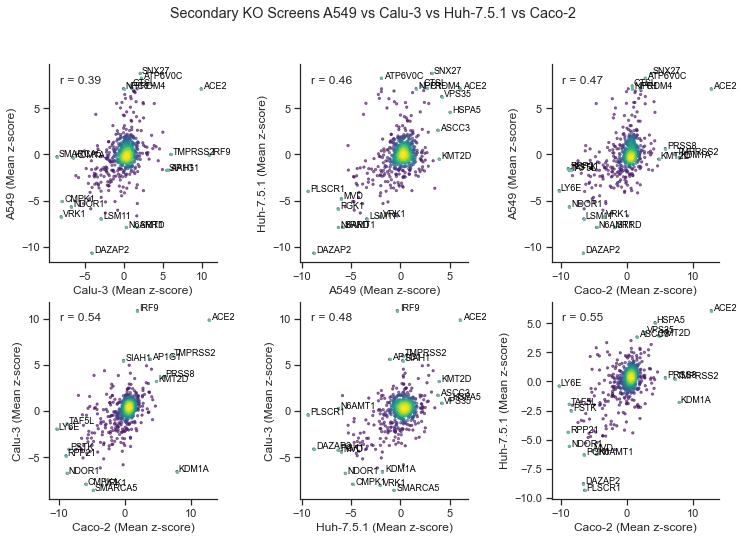

In [40]:
# Read in processed z-scores for all secondary activation screens
Calu3_Secondary_KO = pd.read_excel('Data/GSE193834_Supplemental_File_11_Calu-3_Cas9_KO_SecondaryLibrary_Goujon.xlsx')
A549_Secondary_KO = pd.read_excel('Data/GSE193834_Supplemental_File_8_A549-ACE2_KO_SecondaryLibrary_Goujon.xlsx')
Huh751_Secondary_KO = pd.read_excel('Data/GSE193834_Supplemental_File_9_Huh7.5.1-ACE2_KO_SecondaryLibrary_Goujon.xlsx')
Caco2_Secondary_KO = pd.read_excel('Data/GSE193834_Supplemental_File_10_Caco-2-ACE2_KO_SecondaryLibrary_Goujon.xlsx')

SecondaryKO = pd.merge(pd.merge(Calu3_Secondary_KO, Caco2_Secondary_KO, on = 'Gene Symbol', how = 'inner', suffixes = ['_Calu3', '_Caco2']),
                        pd.merge(A549_Secondary_KO, Huh751_Secondary_KO, on = 'Gene Symbol', how = 'inner', suffixes = ['_A549', '_Huh751']),
                       on = 'Gene Symbol', how = 'inner')

top_ranked_Calu3 = SecondaryKO.nlargest(5, 'residual_zscore_avg_Calu3')
bottom_ranked_Calu3 = SecondaryKO.nsmallest(5, 'residual_zscore_avg_Calu3')
top_ranked_A549 = SecondaryKO.nlargest(5, 'residual_zscore_avg_A549')
bottom_ranked_A549 = SecondaryKO.nsmallest(5, 'residual_zscore_avg_A549')
top_ranked_Huh751 = SecondaryKO.nlargest(5, 'residual_zscore_avg_Huh751')
bottom_ranked_Huh751 = SecondaryKO.nsmallest(5, 'residual_zscore_avg_Huh751')
top_ranked_Caco2 = SecondaryKO.nlargest(5, 'residual_zscore_avg_Caco2')
bottom_ranked_Caco2 = SecondaryKO.nsmallest(5, 'residual_zscore_avg_Caco2')

Calu3_ranked = pd.concat([top_ranked_Calu3, bottom_ranked_Calu3])
A549_ranked = pd.concat([top_ranked_A549, bottom_ranked_A549])
Huh751_ranked = pd.concat([top_ranked_Huh751, bottom_ranked_Huh751])
Caco2_ranked = pd.concat([top_ranked_Caco2, bottom_ranked_Caco2])

fig, axs = plt.subplots(nrows = 2, ncols= 3, figsize=(12, 8))

# A549 vs Calu-3
gpp.point_densityplot(data = SecondaryKO, x = 'residual_zscore_avg_Calu3', y = 'residual_zscore_avg_A549', s=6, ax = axs[0,0])
ax = gpp.add_correlation(SecondaryKO.dropna(), 'residual_zscore_avg_Calu3', 'residual_zscore_avg_A549', loc = 'upper left', ax = axs[0,0])

# Annotate
annot_df_Calu3_A549 = pd.concat([Calu3_ranked, A549_ranked]).drop_duplicates()
sns.scatterplot(data=annot_df_Calu3_A549, x='residual_zscore_avg_Calu3', y='residual_zscore_avg_A549', color = sns.color_palette('Set2')[0], edgecolor=None, s=6, ax=axs[0,0])

texts= []
for j, row in annot_df_Calu3_A549.iterrows():
    texts.append(axs[0,0].text(row['residual_zscore_avg_Calu3']+0.25, row['residual_zscore_avg_A549'], row['Gene Symbol'], fontsize=9,
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)

axs[0,0].set_xlabel('Calu-3 (Mean z-score)')
axs[0,0].set_ylabel('A549 (Mean z-score)')


# A549 vs Huh-7.5.1 
gpp.point_densityplot(data = SecondaryKO, x = 'residual_zscore_avg_Huh751', y = 'residual_zscore_avg_A549', s=6, ax = axs[0,1])
ax = gpp.add_correlation(SecondaryKO.dropna(), 'residual_zscore_avg_Huh751', 'residual_zscore_avg_A549', loc = 'upper left', ax = axs[0,1])

# Annotate
annot_df_A549_Huh751 = pd.concat([A549_ranked, Huh751_ranked]).drop_duplicates()
sns.scatterplot(data=annot_df_A549_Huh751, x='residual_zscore_avg_Huh751', y='residual_zscore_avg_A549', color = sns.color_palette('Set2')[0], edgecolor=None, s=6, ax=axs[0,1])

texts= []
for j, row in annot_df_A549_Huh751.iterrows():
    texts.append(axs[0,1].text(row['residual_zscore_avg_Huh751']+0.25, row['residual_zscore_avg_A549'], row['Gene Symbol'], fontsize=9,
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)

axs[0,1].set_xlabel('A549 (Mean z-score)')
axs[0,1].set_ylabel('Huh-7.5.1 (Mean z-score)')

# A549 vs Caco-2
gpp.point_densityplot(data = SecondaryKO, x = 'residual_zscore_avg_Caco2', y = 'residual_zscore_avg_A549', s=6, ax = axs[0,2])
ax = gpp.add_correlation(SecondaryKO.dropna(), 'residual_zscore_avg_Caco2', 'residual_zscore_avg_A549', loc = 'upper left', ax = axs[0,2])

# Annotate
annot_df_Caco2_A549 = pd.concat([Caco2_ranked, A549_ranked]).drop_duplicates()
sns.scatterplot(data=annot_df_Caco2_A549, x='residual_zscore_avg_Caco2', y='residual_zscore_avg_A549', color = sns.color_palette('Set2')[0], edgecolor=None, s=6, ax=axs[0,2])

texts= []
for j, row in annot_df_Caco2_A549.iterrows():
    texts.append(axs[0,2].text(row['residual_zscore_avg_Caco2']+0.25, row['residual_zscore_avg_A549'], row['Gene Symbol'], fontsize=9,
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)

axs[0,2].set_xlabel('Caco-2 (Mean z-score)')
axs[0,2].set_ylabel('A549 (Mean z-score)')

# Calu-3 vs Caco-2
gpp.point_densityplot(data = SecondaryKO, x = 'residual_zscore_avg_Caco2', y = 'residual_zscore_avg_Calu3', s=6, ax = axs[1,0])
ax = gpp.add_correlation(SecondaryKO.dropna(), 'residual_zscore_avg_Caco2', 'residual_zscore_avg_Calu3', loc = 'upper left', ax = axs[1,0])

# Annotate
annot_df_Caco2_Calu3 = pd.concat([Caco2_ranked, Calu3_ranked]).drop_duplicates().dropna()
sns.scatterplot(data=annot_df_Caco2_Calu3, x='residual_zscore_avg_Caco2', y='residual_zscore_avg_Calu3', color = sns.color_palette('Set2')[0], edgecolor=None, s=6, ax=axs[1,0])

texts= []
for j, row in annot_df_Caco2_Calu3.iterrows():
    texts.append(axs[1,0].text(row['residual_zscore_avg_Caco2']+0.25, row['residual_zscore_avg_Calu3'], row['Gene Symbol'], fontsize=9,
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)

axs[1,0].set_xlabel('Caco-2 (Mean z-score)')
axs[1,0].set_ylabel('Calu-3 (Mean z-score)')

# Calu-3 vs Huh-7.5.1
gpp.point_densityplot(data = SecondaryKO, x = 'residual_zscore_avg_Huh751', y = 'residual_zscore_avg_Calu3', s=6, ax = axs[1,1])
ax = gpp.add_correlation(SecondaryKO.dropna(), 'residual_zscore_avg_Huh751', 'residual_zscore_avg_Calu3', loc = 'upper left', ax = axs[1,1])

# Annotate
annot_df_Calu3_Huh751 = pd.concat([Calu3_ranked, Huh751_ranked]).drop_duplicates()
sns.scatterplot(data=annot_df_Calu3_Huh751, x='residual_zscore_avg_Huh751', y='residual_zscore_avg_Calu3', color = sns.color_palette('Set2')[0], edgecolor=None, s=6, ax=axs[1,1])

texts= []
for j, row in annot_df_Calu3_Huh751.iterrows():
    texts.append(axs[1,1].text(row['residual_zscore_avg_Huh751']+0.25, row['residual_zscore_avg_Calu3'], row['Gene Symbol'], fontsize=9,
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)

axs[1,1].set_xlabel('Huh-7.5.1 (Mean z-score)')
axs[1,1].set_ylabel('Calu-3 (Mean z-score)')

# Huh-7.5.1 vs Caco-2
gpp.point_densityplot(data = SecondaryKO, x = 'residual_zscore_avg_Caco2', y = 'residual_zscore_avg_Huh751', s=6, ax = axs[1,2])
ax = gpp.add_correlation(SecondaryKO.dropna(), 'residual_zscore_avg_Caco2', 'residual_zscore_avg_Huh751', loc = 'upper left', ax = axs[1,2])

# Annotate
annot_df_Caco2_Huh751 = pd.concat([Caco2_ranked, Huh751_ranked]).drop_duplicates()
sns.scatterplot(data=annot_df_Caco2_Huh751, x='residual_zscore_avg_Caco2', y='residual_zscore_avg_Huh751', color = sns.color_palette('Set2')[0], edgecolor=None, s=6, ax=axs[1,2])

texts= []
for j, row in annot_df_Caco2_Huh751.iterrows():
    texts.append(axs[1,2].text(row['residual_zscore_avg_Caco2']+0.25, row['residual_zscore_avg_Huh751'], row['Gene Symbol'], fontsize=9,
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)

axs[1,2].set_xlabel('Caco-2 (Mean z-score)')
axs[1,2].set_ylabel('Huh-7.5.1 (Mean z-score)')

sns.despine()
plt.suptitle('Secondary KO Screens A549 vs Calu-3 vs Huh-7.5.1 vs Caco-2')
plt.subplots_adjust(wspace=0.5)

# gpp.savefig('../../../Figures/Scatterplots/SecondaryKOScreenComparison_Calu3A549Huh751.pdf', dpi=300)


### Heatmap

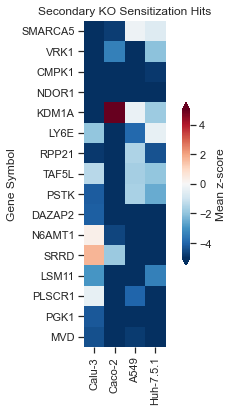

In [41]:
rank_cols = [col for col in SecondaryKO.columns if 'Rank' in col]
sensitization_heatmap_df = select_top_ranks(SecondaryKO.drop(rank_cols, axis=1), largest=False)
# sensitization_heatmap_df=sensitization_heatmap_df.sort_values(by=list(sensitization_heatmap_df.columns[1:]), ascending=False)
# sensitization_heatmap_df = SecondaryKO.drop(rank_cols, axis=1)
Secondary_KO_sensitization_heatmap = sensitization_heatmap_df.copy().set_index('Gene Symbol').dropna(axis = 0)

fig, ax = plt.subplots(figsize=(6, 6))

xlabels = ['Calu-3', 'Caco-2', 'A549', 'Huh-7.5.1']

g = sns.heatmap(Secondary_KO_sensitization_heatmap, cmap = gpp.diverging_cmap(), xticklabels=xlabels, 
                yticklabels=True, square=True, vmin=-5, vmax=5, cbar_kws={'shrink':0.5, 'extend':'both', 'label':'Mean z-score'},
               center = 0);
plt.title('Secondary KO Sensitization Hits');

# gpp.savefig('../../../Figures/Heatmaps/Secondary_KO_sensitization_heatmap.pdf', dpi=300, bbox_inches = 'tight')
# fig.savefig('../../../Figures/Heatmaps/Secondary_KO_sensitization_heatmap.png', dpi=300, bbox_inches = 'tight')


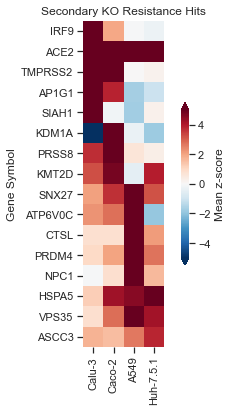

In [42]:
resistance_heatmap_df = select_top_ranks(SecondaryKO.drop(rank_cols, axis=1), largest=True)
# resistance_heatmap_df=resistance_heatmap_df.sort_values(by=list(resistance_heatmap_df.columns[1:]), ascending=False)
# rank_cols = [col for col in resistance_heatmap_df.columns if 'Rank' in col]
# resistance_heatmap_df = resistance_heatmap_df.drop(rank_cols, axis=1)
Secondary_Act_resistance_heatmap = resistance_heatmap_df.copy().set_index('Gene Symbol').dropna(axis = 0)

fig, ax = plt.subplots(figsize=(6, 6))

xlabels = ['Calu-3', 'Caco-2', 'A549', 'Huh-7.5.1']

g = sns.heatmap(Secondary_Act_resistance_heatmap, cmap = gpp.diverging_cmap(), xticklabels=xlabels, yticklabels=True, square=True, vmin = -5, vmax = 5, cbar_kws={'shrink':0.5, 'label':'Mean z-score', 'extend':'both'},
               center = 0)
plt.title('Secondary KO Resistance Hits');

# gpp.savefig('../../../Figures/Heatmaps/Secondary_KO_resistance_heatmap.pdf', dpi=300, bbox_inches = 'tight')
# fig.savefig('../../../Figures/Heatmaps/Secondary_KO_resistance_heatmap.png', dpi=300, bbox_inches = 'tight')